### Imports & Setup

In [6]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

import joblib


### Load Features & Extract Actor IDs

In [7]:
df = pd.read_csv("features.csv")

X = df.iloc[:, :-1].values
y = df["emotion"].values

# Extract actor-id from stored filename column if available,
# otherwise infer from RAVDESS pattern
if "filename" in df.columns:
    filenames = df["filename"].tolist()
else:
    # optional: store filenames earlier in extraction
    filenames = [None] * len(df)

def get_actor_id(name):
    if name is None:
        return 0
    return int(name.split("-")[6].split(".")[0])

groups = [get_actor_id(f) for f in filenames]

print("Total samples:", len(X))


Total samples: 1440


### Train-Val-Test Split (70-15-15)

In [8]:
# First split train (70%) vs temp (30%)
X_train, X_temp, y_train, y_temp, groups_train, groups_temp = train_test_split(
    X, y, groups,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# Split remaining into 15/15 (val/test)
X_val, X_test, y_val, y_test, groups_val, groups_test = train_test_split(
    X_temp, y_temp, groups_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Train:", len(X_train))
print("Val:", len(X_val))
print("Test:", len(X_test))


Train: 1008
Val: 216
Test: 216


### Standardization & Save Scaler   

In [9]:
import os
os.makedirs("artifacts", exist_ok=True)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, "artifacts/standard_scaler.pkl")
print("Scaler saved.")


Scaler saved.


### Baseline Models (Default Parameters), SVM baseline

In [10]:
svm_baseline = SVC(probability=True, random_state=42)
svm_baseline.fit(X_train_scaled, y_train)

y_val_pred_svm_base = svm_baseline.predict(X_val_scaled)

baseline_svm_val_acc = accuracy_score(y_val, y_val_pred_svm_base)
print("Baseline SVM Validation Accuracy:", baseline_svm_val_acc)


Baseline SVM Validation Accuracy: 0.8055555555555556


### Random Forest Baseline

In [11]:
rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train_scaled, y_train)

y_val_pred_rf_base = rf_baseline.predict(X_val_scaled)

baseline_rf_val_acc = accuracy_score(y_val, y_val_pred_rf_base)
print("Baseline RF Validation Accuracy:", baseline_rf_val_acc)


Baseline RF Validation Accuracy: 0.8981481481481481


### Hyperparameter Tuning (GridSearchCV)

In [12]:
group_kfold = GroupKFold(n_splits=5)

#----------------------
# SVM Grid Search
#----------------------

svm_param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto", 0.001, 0.01, 0.1],
    "kernel": ["rbf", "linear"]
}

svm_grid = GridSearchCV(
    SVC(probability=True, random_state=42),
    svm_param_grid,
    cv=group_kfold.split(X_train_scaled, y_train, groups_train),
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

svm_grid.fit(X_train_scaled, y_train)

best_svm = svm_grid.best_estimator_

print("Best SVM Params:", svm_grid.best_params_)
print("Best SVM CV Score:", svm_grid.best_score_)

#Validation performance:

y_val_pred_svm = best_svm.predict(X_val_scaled)
svm_val_acc = accuracy_score(y_val, y_val_pred_svm)
print("Tuned SVM Validation Accuracy:", svm_val_acc)

#----------------------
# RF Grid Search
#----------------------

rf_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=group_kfold.split(X_train_scaled, y_train, groups_train),
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(X_train_scaled, y_train)

best_rf = rf_grid.best_estimator_

print("Best RF Params:", rf_grid.best_params_)
print("Best RF CV Score:", rf_grid.best_score_)

#Validation:

y_val_pred_rf = best_rf.predict(X_val_scaled)
rf_val_acc = accuracy_score(y_val, y_val_pred_rf)
print("Tuned RF Validation Accuracy:", rf_val_acc)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best SVM Params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM CV Score: 0.8091157279029131
Tuned SVM Validation Accuracy: 0.9259259259259259
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best RF Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best RF CV Score: 0.8695505194017781
Tuned RF Validation Accuracy: 0.9120370370370371


In [13]:
# Save the best models

os.makedirs("artifacts", exist_ok=True)

joblib.dump(best_svm, "artifacts/svm_model.pkl")
joblib.dump(best_rf, "artifacts/random_forest_model.pkl")

print("Models saved.")


Models saved.


### Confusion Matrices

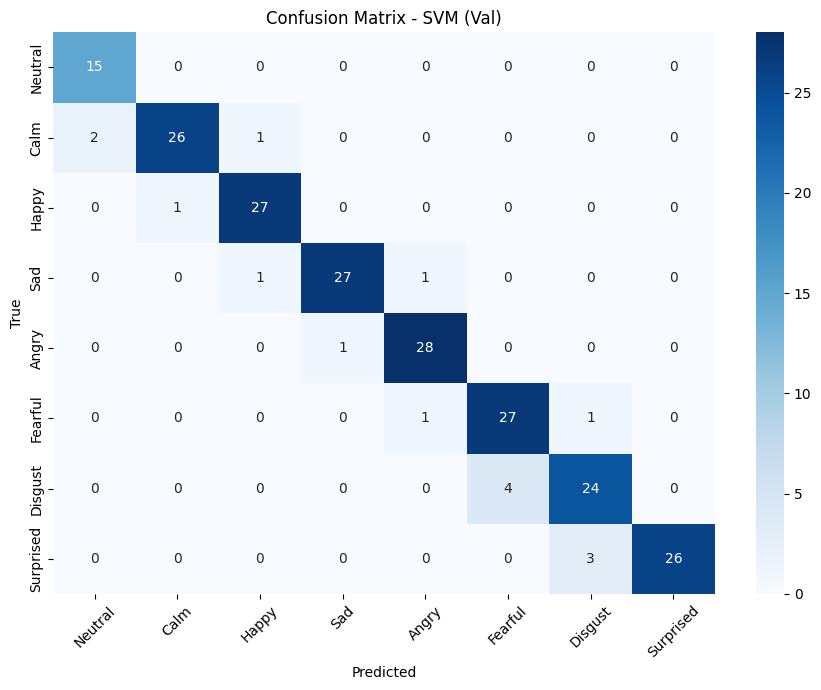

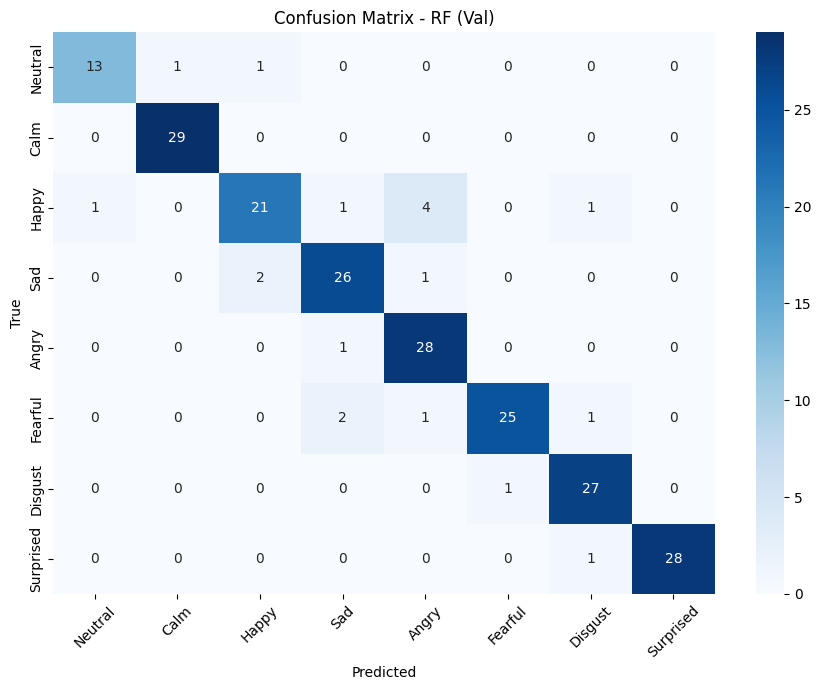


===== SVM Classification Report (Validation) =====

              precision    recall  f1-score   support

     Neutral       0.88      1.00      0.94        15
        Calm       0.96      0.90      0.93        29
       Happy       0.93      0.96      0.95        28
         Sad       0.96      0.93      0.95        29
       Angry       0.93      0.97      0.95        29
     Fearful       0.87      0.93      0.90        29
     Disgust       0.86      0.86      0.86        28
   Surprised       1.00      0.90      0.95        29

    accuracy                           0.93       216
   macro avg       0.93      0.93      0.93       216
weighted avg       0.93      0.93      0.93       216


===== Random Forest Classification Report (Validation) =====

              precision    recall  f1-score   support

     Neutral       0.93      0.87      0.90        15
        Calm       0.97      1.00      0.98        29
       Happy       0.88      0.75      0.81        28
         Sad    

In [18]:
emotion_labels = [
"Neutral","Calm","Happy","Sad",
"Angry","Fearful","Disgust","Surprised"
]

def save_confusion_matrix(y_true, y_pred, title, filename):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(9,7))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=emotion_labels,
                yticklabels=emotion_labels,
                cmap="Blues")
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

save_confusion_matrix(y_val, y_val_pred_svm,
    "Confusion Matrix - SVM (Val)",
    "artifacts/confusion_svm_val.png")

save_confusion_matrix(y_val, y_val_pred_rf,
    "Confusion Matrix - RF (Val)",
    "artifacts/confusion_rf_val.png")

svm_report = classification_report(y_val, y_val_pred_svm, target_names=emotion_labels)
rf_report = classification_report(y_val, y_val_pred_rf, target_names=emotion_labels)

print("\n===== SVM Classification Report (Validation) =====\n")
print(svm_report)

print("\n===== Random Forest Classification Report (Validation) =====\n")
print(rf_report)

with open("artifacts/svm_classification_report.txt", "w") as f:
    f.write(svm_report)

with open("artifacts/rf_classification_report.txt", "w") as f:
    f.write(rf_report)

print("Reports saved.")


### Model comparision Table

In [16]:
def metrics_summary(y_true, y_pred):
    p,r,f,_ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    acc = accuracy_score(y_true, y_pred)
    return acc,p,r,f

results = []

results.append(["SVM (Baseline)"] + list(metrics_summary(y_val, y_val_pred_svm_base)))
results.append(["RF (Baseline)"] + list(metrics_summary(y_val, y_val_pred_rf_base)))
results.append(["SVM (Tuned)"] + list(metrics_summary(y_val, y_val_pred_svm)))
results.append(["RF (Tuned)"] + list(metrics_summary(y_val, y_val_pred_rf)))

comparison_df = pd.DataFrame(results,
    columns=["Model","Accuracy","Precision","Recall","F1"])

comparison_df.to_csv("artifacts/model_comparison.csv", index=False)

comparison_df


,Model,Accuracy,Precision,Recall,F1
0,SVM (Baseline),0.805556,0.815173,0.805357,0.801072
1,RF (Baseline),0.898148,0.902166,0.895895,0.896706
2,SVM (Tuned),0.925926,0.925260,0.930265,0.926570
3,RF (Tuned),0.912037,0.915247,0.908826,0.910015
